# Insight Data presentation - July 11 2016

### Objective: Use statistics, time series and machine learning to characterize 'tweeter speech' from Donald Trump and Hillary Clinton: What can we learn about their tweets?

Analysis keypoints:
 1. Use tweepy to download the tweets authored by each candidate.
 2. Analysis of Hashtag frequency - What can we learn?
 3. Time series analysis - Number of tweets/correlation - Locate peaks
 4. Word histogram - What are the words more frequently used by either candidate? What can we learn?
 5. But... humans are biased, are they not? Can we do better? Use machine learning!
 6. What about unsupervised learning? Does a predictive model make sense?

In [2]:
import json
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import glob
import datetime
from email.utils import parsedate_tz
import pandas as pd
import tokenizer
import numpy as np
%matplotlib inline

Load file name with tweets (tweepy used on Friday to get new data):

In [3]:
Clinton_tfile = glob.glob('/home/carlosj/projects_venv/project_ttr/insight_presentation/data/Clinton_tweets/*')
Trump_tfile = glob.glob('/home/carlosj/projects_venv/project_ttr/insight_presentation/data/Trump_tweets/*')

In [4]:
#Function useful to convert time string to timedate format to use with Pandas.
def to_datetime(datestring):
    time_tuple = parsedate_tz(datestring.strip())
    dt = datetime.datetime(*time_tuple[:6])
    return dt - datetime.timedelta(seconds=time_tuple[-1])

In [5]:
#Read and store the text of the tweets from start_date to end_date
def read_tweets_text(datafile, start_date, end_date):
    raw_data_complete= open(datafile);
    tweets_list = []
    start = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    for line in raw_data_complete.readlines():
        temp = json.loads(line)
        try:
            #use regex to get rid of links
            tweet_date = to_datetime(temp['created_at'])
            if tweet_date >= start and tweet_date <= end:
                tweets_list.append(re.sub('(htt|www).?[^\s]+', ' LINK ', temp['text']))
        except:
            pass
    return tweets_list

## 1. Hashtag frequency of candidates  (2016)

In [6]:
#Extract hashtags from tweets, create a dictionary with hashtag frequency
def most_used_hashtags(datafile, start, end, number_hash=10):
    data_list = read_tweets_text(datafile, start, end)
    words = []
    for tweet in data_list:
        #for word in re.split('\s',tweet):
        words.extend('#' + x.lower() for x in re.findall(r"#(\w+)", tweet))
            #if ('#' in word):
                #words.append(re.split('\W', word)[1].lower())
    #create a dictionary where the values are the frequency of the hashtags
    c = Counter(words)
    return c.most_common(number_hash)

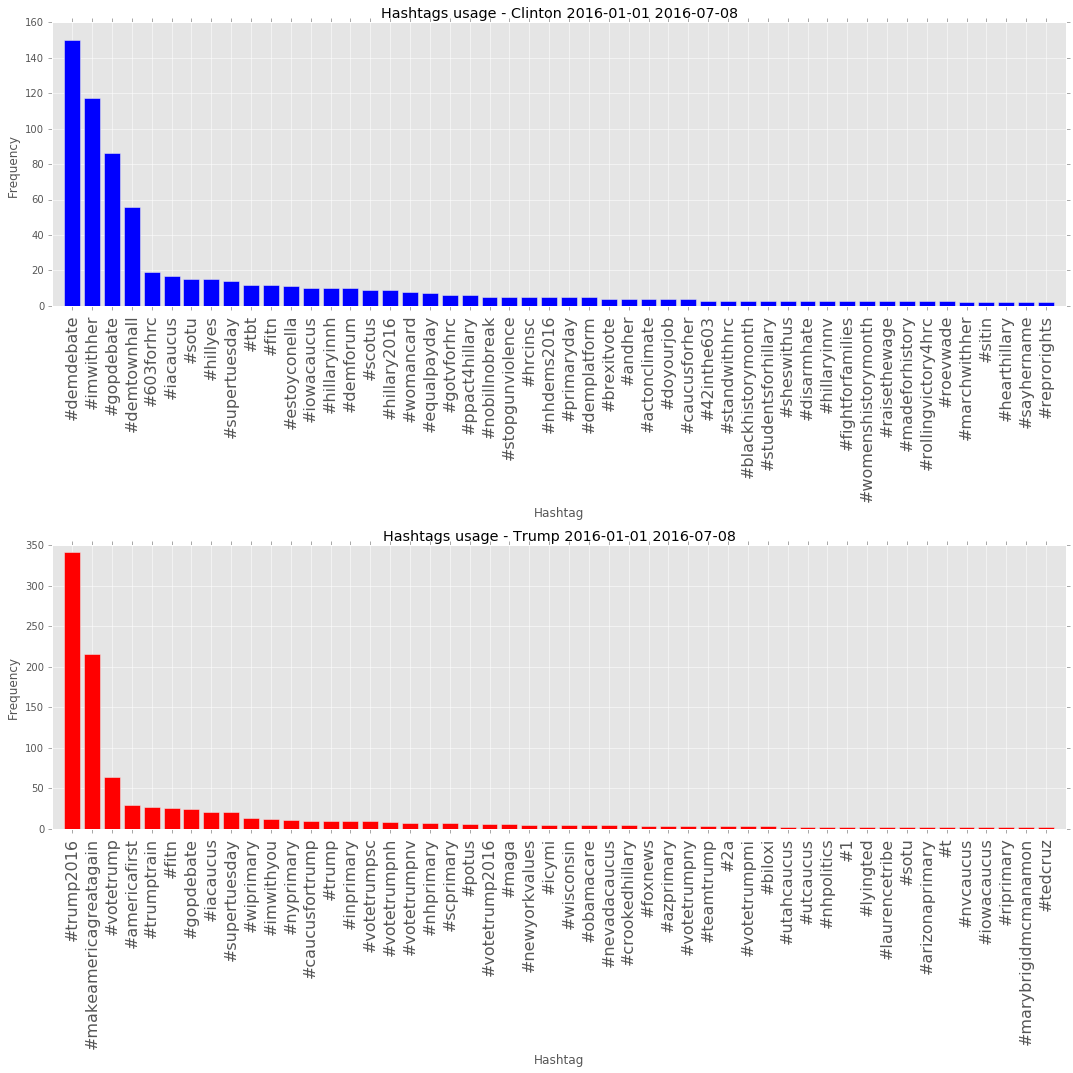

In [7]:
# Fun begins - Plot hashtag histogram of the data - Clinton/Trump tweets
plt.style.use('ggplot')
n_hast = 50
plt.figure(figsize=(15,15))
start_date = '2016-01-01'
end_date = '2016-07-08'

plt.subplot(2, 1, 1)
msh_Clint = most_used_hashtags(Clinton_tfile[0], start_date, end_date, n_hast)
plt.bar(range(n_hast), [x[1] for x in msh_Clint], width=0.8, align = 'center', color = 'b')
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.title(r'Hashtags usage - Clinton %s %s' % (start_date, end_date))
plt.xticks(range(n_hast), [x[0] for x in msh_Clint], rotation=90, fontsize = 16)
plt.gca().set_xlim(left=-1)
plt.tight_layout()

plt.subplot(2, 1, 2)
msh_Trump = most_used_hashtags(Trump_tfile[0], start_date, end_date, n_hast)
plt.bar(range(n_hast), [x[1] for x in msh_Trump], width=0.8, align = 'center', color = 'r')
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.title(r'Hashtags usage - Trump %s %s' % (start_date, end_date))
plt.xticks(range(n_hast), [x[0] for x in msh_Trump], rotation=90 ,fontsize = 16)
#plt.axis([-1, n_hast+1, 0, 450])
plt.gca().set_xlim(left=-1)
plt.tight_layout()
plt.show()

## 2. Time series analysis (2016) 

In [8]:
#Extract number of tweets per date, create dictionaries with information.
dates = []
f = open(Clinton_tfile[0],'rU')
data = f.readlines()
for line in data:
    dates.append(to_datetime(json.loads(line)['created_at']))
tts_per_day_Clinton = sorted(Counter([x-datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second)\
                                      for x in dates if x.year == 2016]).iteritems())

dates = []
f = open(Trump_tfile[0],'rU')
data = f.readlines()
for line in data:
    dates.append(to_datetime(json.loads(line)['created_at']))
tts_per_day_Trump = sorted(Counter([x-datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second)\
                                    for x in dates if x.year == 2016]).iteritems())

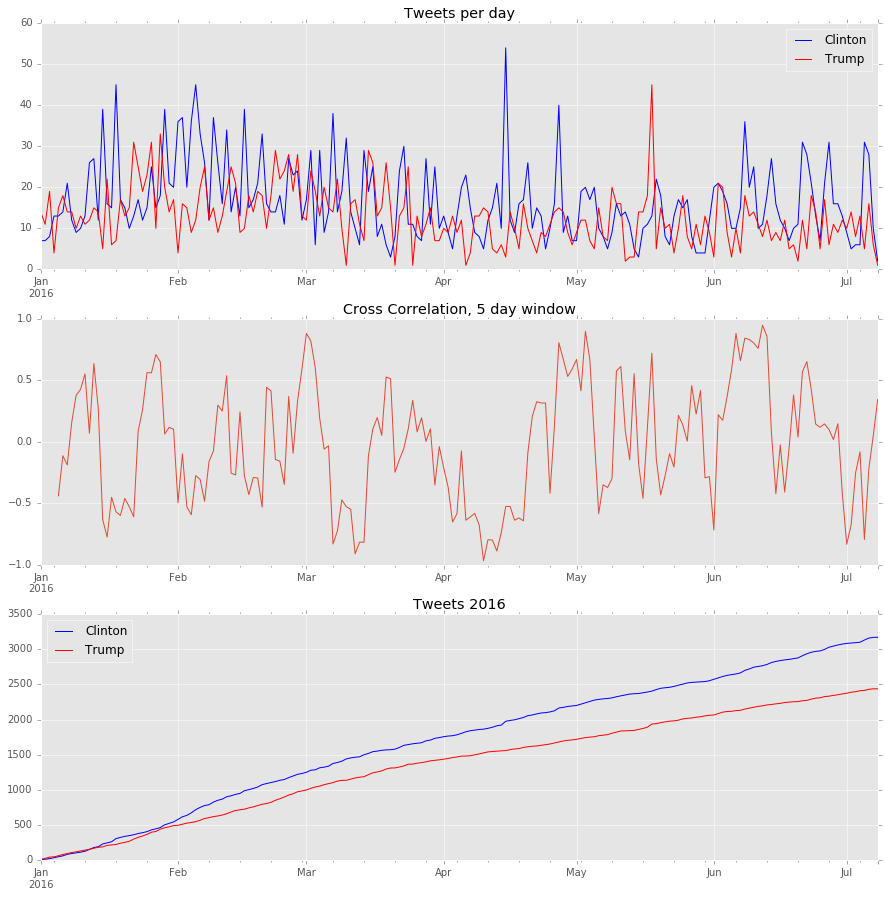

In [9]:
# Use Pandas to convert dictionaries to time series, and plot tweets/day, 
#cross correlation, running sum per candidate

plt.style.use('ggplot')
Trump_tws_day = pd.DatetimeIndex([x[0] for x in tts_per_day_Trump])
Clinton_tws_day = pd.DatetimeIndex([x[0] for x in tts_per_day_Trump])
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
Clinton_ts = pd.Series([x[1] for x in tts_per_day_Clinton], index= Clinton_tws_day)
Trump_ts = pd.Series([x[1] for x in tts_per_day_Trump], index= Trump_tws_day)
Clinton_ts.plot(title = 'Tweets per day', label = 'Clinton', color = 'b')
Trump_ts.plot(label = 'Trump', color = 'r')
plt.legend()

plt.subplot(3, 1, 2)
a1 =pd.Series([x[1] for x in tts_per_day_Clinton])
a2 = pd.Series([x[1] for x in tts_per_day_Trump])
a3 = a1.rolling(window=5).corr(a2)
ts = pd.Series(a3.tolist(), index = Clinton_tws_day)
ts.plot(title = 'Cross Correlation, 5 day window')

plt.subplot(3, 1, 3)
Clinton_ts.cumsum().plot(title = 'Tweets 2016', label = 'Clinton', color = 'b')
Trump_ts.cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')
plt.show()


In [10]:
print 'Date of max tweets (Clinton): ' + str(Clinton_ts.idxmax()) + ' -- number of tweets: ' + str(Clinton_ts.max())
print 'Date of max tweets (Trump): ' + str(Trump_ts.idxmax()) + ' -- number of tweets: ' + str(Trump_ts.max())

Date of max tweets (Clinton): 2016-04-15 00:00:00 -- number of tweets: 54
Date of max tweets (Trump): 2016-05-18 00:00:00 -- number of tweets: 45


In [10]:
most_used_hashtags(Clinton_tfile[0], '2016-04-14', '2016-04-16', 10)

[(u'#demdebate', 32),
 (u'#tbt', 2),
 (u'#womenofcolor', 1),
 (u'#brooklyndebate', 1),
 (u'#dayofsilence', 1),
 (u'#equalpay', 1),
 (u'#lssc', 1),
 (u'#imwithher', 1)]

Aprli 15 was the day of the Dem debate in NYC!

In [11]:
most_used_hashtags(Trump_tfile[0], '2016-05-17', '2016-05-19', 10)

[(u'#makeamericagreatagain', 5),
 (u'#trump2016', 3),
 (u'#orprimary', 1),
 (u'#americafirst', 1),
 (u'#megynkellypresents', 1),
 (u'#votetrump', 1),
 (u'#trump', 1)]

No clear indication from the hashtags on cause of peak.

## 3. Words used in tweets for either candidate - histogram

In [12]:
#Create a list with the list of most commonly used words/verbs in English. Useful for filtering irrelevant info

words_list_file = "most_used_words_en.txt" #File with words
verbs_list_file = 'most_used_verbs_en.txt' #File with verbs
common_word = []
common_verb = []
try:
    with open(words_list_file, 'r') as f:
        for line in f.readlines():
            common_word.append(line.rstrip())
except:
    print "File not found!!"
try:
    with open(verbs_list_file, 'r') as f:
        for line in f.readlines():
            common_verb.append(line.rstrip())
except:
    print "File not found!!"

In [13]:
#Use own version of "tokenizer" to clean tweets and leave only text. Returns a dict with words and frequency
def most_used_words(datafile, w_num, wf_num, w_len, start_date, end_date):
    data_clean = tokenizer.getDATA(datafile, 'y')
    words = []
    for tweet in data_clean:
        start = datetime.datetime.strptime(start_date, '%Y-%m-%d')
        end = datetime.datetime.strptime(end_date, '%Y-%m-%d')
        if (to_datetime(tweet[1]) >= start and to_datetime(tweet[1]) <= end):
            temp =  re.split('\s+', tweet[0].rstrip())    
            for x in temp:
                if 'TK.' not in x and x.lower() not in common_word[:wf_num]:
                    if (x.lower() not in common_verb[:wf_num] and len(x) > w_len):
                        words.append(x.lower())
    return Counter(words).most_common(w_num)

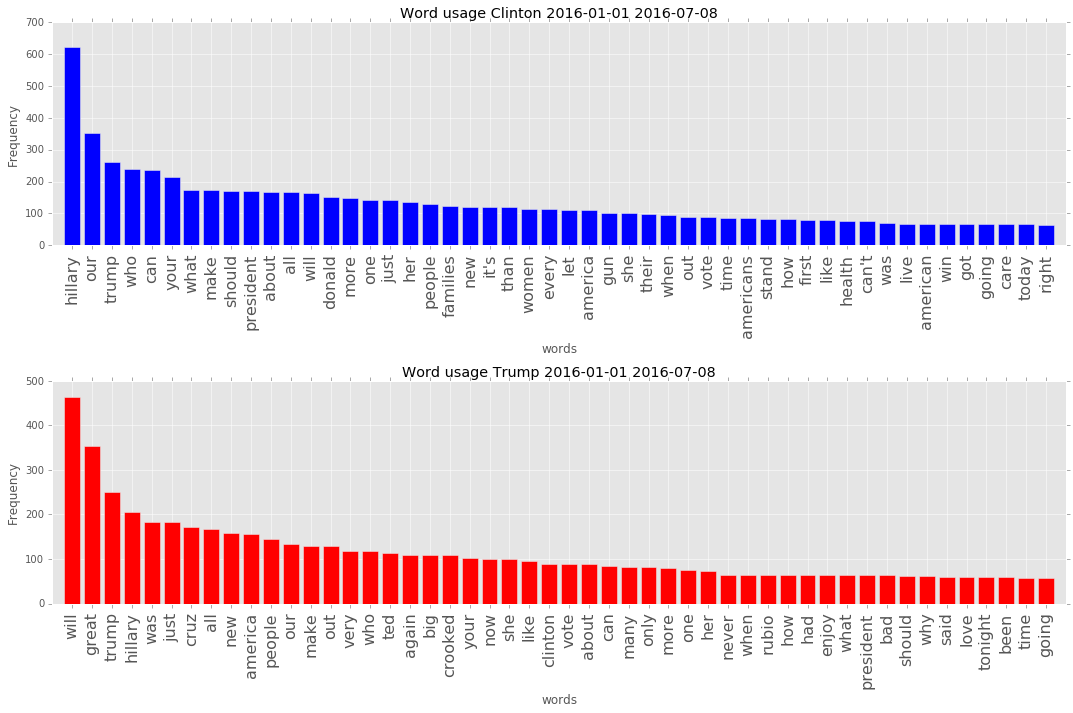

In [14]:
# Histogram fo most common words in tweets
w_num = 50
wf_num = 30
w_sz_min = 2
start_date = '2016-01-01'
end_date = '2016-07-08'
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
muw_Clinton = most_used_words(Clinton_tfile[0], w_num, wf_num, w_sz_min, start_date, end_date)
plt.bar(range(w_num), [x[1] for x in muw_Clinton], width=0.8, align = 'center', color = 'b')
plt.xlabel('words')
plt.ylabel('Frequency')
plt.title(r'Word usage Clinton %s %s' % (start_date, end_date))
plt.xticks(range(w_num), [x[0] for x in muw_Clinton], rotation= 90, fontsize = 16)
plt.gca().set_xlim(left=-1)
#plt.axis([-1, 50, 0, 700])

plt.subplot(2, 1, 2)
muw_Trump = most_used_words(Trump_tfile[0], w_num, wf_num, w_sz_min, start_date, end_date)
plt.bar(range(w_num), [x[1] for x in muw_Trump], \
        width=0.8, align = 'center', color='r')
plt.xlabel('words')
plt.ylabel('Frequency')
plt.title(r'Word usage Trump %s %s' % (start_date, end_date))
plt.xticks(range(w_num), [x[0] for x in muw_Trump],\
           rotation= 90, fontsize = 16)
#plt.axis([-1, 50, 0, 700])
plt.gca().set_xlim(left=-1)
plt.tight_layout()
plt.show()

Clinton's words seem longer, more substantive issues. Trump's are more adjetives/candidate names!

Lets explore again the peak dates in the tweets of each candidate:

In [15]:
most_used_words(Clinton_tfile[0], 10, wf_num, w_sz_min, '2016-04-14', '2016-04-16')

[(u'hillary', 13),
 (u'gun', 8),
 (u'who', 6),
 (u'should', 6),
 (u"it's", 6),
 (u'our', 5),
 (u'one', 5),
 (u'sanders', 5),
 (u'candidate', 5),
 (u'health', 4)]

Dem debate - NYC - April 15

In [16]:
most_used_words(Trump_tfile[0], 20, wf_num, w_sz_min, '2016-05-17', '2016-05-19')

[(u'hillary', 13),
 (u'will', 12),
 (u'trump', 11),
 (u'crooked', 10),
 (u'great', 9),
 (u'she', 9),
 (u'interview', 7),
 (u'was', 7),
 (u'very', 5),
 (u'can', 5),
 (u'president', 5),
 (u"can't", 5),
 (u'all', 4),
 (u'ever', 4),
 (u'oregon', 4),
 (u'how', 4),
 (u'now', 4),
 (u'should', 4),
 (u'hit', 4),
 (u'thanks.', 4)]

Ex-Aide to Hillary Clinton Testifies About Email Server - May 18 - NYT/ Trump interview Fox News

## 5. Can we characterize the "speech" of each candidate, without human bias?

In [17]:
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, grid_search
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier

In [18]:
#Clean text with own tokenizer
clinton_data_TK = tokenizer.getDATA(Clinton_tfile[0], 'n')
clinton_data = [re.sub('[TK.].?[^\s]+',' ',x) for x in clinton_data_TK]
trump_data_TK = tokenizer.getDATA(Trump_tfile[0], 'n')
trump_data = [re.sub('[TK.].?[^\s]+',' ',x) for x in trump_data_TK]

In [19]:
print 'clinton tweets= ' + str(len(clinton_data)) + ' trump tweets= ' + str(len(trump_data))

clinton tweets= 3200 trump tweets= 3143


In [20]:
np.random.shuffle(trump_data)
np.random.shuffle(clinton_data)

In [21]:
#Vectorizer for going from words -> numbers
vectorizer = TfidfVectorizer(min_df=5,
                                 max_df = 0.8,
                                 sublinear_tf=True,
                                 use_idf=True)

In [22]:
#Pick subset of data to train a predictive model with Trump/Clinton classes
clinton_train = clinton_data[:1800]; trump_train = trump_data[:1800]

In [23]:
X_train = vectorizer.fit_transform(clinton_train+trump_train);
y_train = ['Clinton' for _ in range(len(clinton_train))] + ['Trump' for _ in range(len(trump_train))]

In [24]:
#Choose SVM/linear kernel as classifier
clf_linear = svm.SVC(kernel='linear')

In [25]:
clf_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
#Define validation set
trump_val = trump_data[1800:2400]; clinton_val = clinton_data[1800:2400];
y_val = ['Clinton' for _ in range(len(clinton_val))] + ['Trump' for _ in range(len(trump_val))]

In [27]:
pr_linear_val = clf_linear.predict(vectorizer.transform(clinton_val+trump_val))

In [28]:
#Evaluate predictive power in validating set
print classification_report(y_val, pr_linear_val)

             precision    recall  f1-score   support

    Clinton       0.86      0.89      0.88       600
      Trump       0.89      0.86      0.87       600

avg / total       0.88      0.88      0.88      1200



In [29]:
#Define test set for classifier
trump_test = trump_data[2400:]; clinton_test = clinton_data[2400:];
y_test = ['Clinton' for _ in range(len(clinton_test))] + ['Trump' for _ in range(len(trump_test))]

In [30]:
pr_linear_test = clf_linear.predict(vectorizer.transform(clinton_test+trump_test))

In [31]:
#Evaluate predictive power in test set
print classification_report(y_test, pr_linear_test)

             precision    recall  f1-score   support

    Clinton       0.87      0.86      0.87       800
      Trump       0.85      0.87      0.86       743

avg / total       0.86      0.86      0.86      1543



Not bad!!!

### Now the fun part... We saw Clinton's/Trump's hashtags/words. The model is (reasonably) successful in predicting tweets authored by each candidate. What are the most relevant features to define a given class? (i.e., what does a tweet have to say to be more "Clintoney" or "Trumpey"?

In [32]:
#Function to extract most important features from classifier (by coeficient value)
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_list = np.array(clf.coef_.todense()).flatten()
    coefs_with_fns = sorted(zip(coefs_list, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

### And... Clinton vs Trump speech (as classified by the model)

In [33]:
show_most_informative_features(vectorizer, clf_linear, 50)

	-3.6358	hillary        		4.3291	crooked        
	-2.1769	lgb            		3.1477	great          
	-2.1211	re             		3.0032	cruz           
	-1.9900	families       		2.7210	will           
	-1.8328	this           		2.2366	poll           
	-1.7490	climate        		2.2077	usa            
	-1.7382	fighting       		2.0858	media          
	-1.7011	few            		2.0510	me             
	-1.6905	woman          		2.0170	failed         
	-1.6524	democratic     		1.9708	obama          
	-1.6466	congress       		1.9487	god            
	-1.6381	we             		1.9189	vo             
	-1.6254	flint          		1.7680	very           
	-1.6205	rhetoric       		1.7349	rubio          
	-1.6201	some           		1.7306	video          
	-1.5937	plan           		1.6919	total          
	-1.5857	fired          		1.6403	jeb            
	-1.5778	violence       		1.6311	record         
	-1.5321	excited        		1.5923	so             
	-1.5302	street         		1.5669	beat           
	-1.5109	himself    

Can we improve the classifier? (Gridsearch)

In [34]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()

In [35]:
clf = grid_search.GridSearchCV(estimator = svr, param_grid = param_grid_svc, cv = 3)
V_data = vectorizer.transform(clinton_data+trump_data)
y_label = ['Clinton' for _ in range(len(clinton_data))] + ['Trump' for _ in range(len(trump_data))]
clf.fit(V_data, y_label)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
clf.best_score_

0.86378685164748537

## 6. What about unsupervised learning? Does a clustering model make sense?

In [38]:
from sklearn.cluster import KMeans

In [117]:
X_data = vectorizer.fit_transform(clinton_data+trump_data)

In [118]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [119]:
reduced_data = PCA(n_components=2).fit_transform(X_data.toarray())
kmeans = KMeans(init='random', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [120]:
h = 0.02

In [121]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [122]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

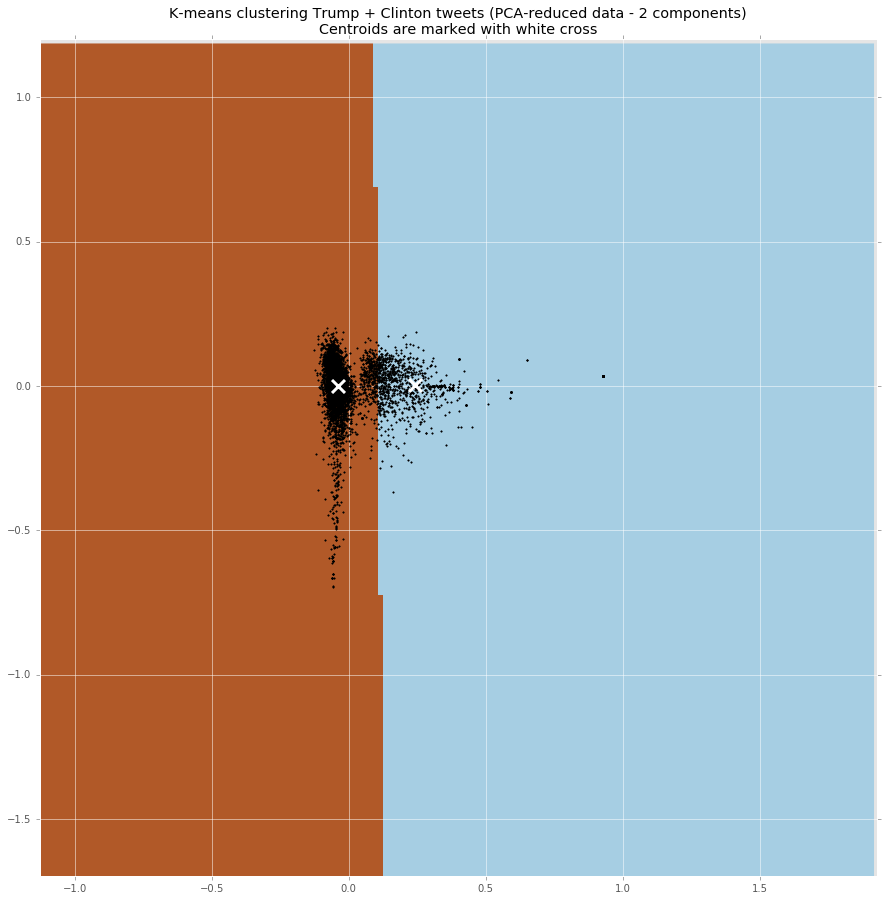

In [123]:
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=3)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering Trump + Clinton tweets (PCA-reduced data - 2 components)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks()
plt.yticks()
plt.show()


Even without training, a simple clustering model separates Trump/Clinton tweets! Also, Trump's tweets (left?) have a smaller dispersion than Clinton's tweets. This means that Trump's tweets are more "monothematic". - This calculation has to be verified!